Author: Carlos Roberto de Melo

Obj: MGE parametrization for pseudo-NFW profile,  eq. S1 of 10.1126/science.aao2469

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mgefit import mge_fit_1d                                       #MGE 1-d parametrization
from jampy.mge_half_light_isophote import mge_half_light_isophote   #Compute half light radius
from jampy.mge_half_light_isophote import mge_half_light_radius     #Compute half light radius (other way)

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

In [3]:
#Reading MGE parametrization
surf, sigma, qobs = np.loadtxt("JAM_Input.txt", unpack=True)
#Fris we will computhe the half ligth radius for the MGE parametrization

In [4]:
#Distance to the galaxy in Mpc
z        = 0.035                                  #Galaxy redshift
distance = cosmo.angular_diameter_distance(z)     #Distance to galaxy [Mpc]
distance

<Quantity 148.43688875 Mpc>

In [5]:
#Computing the half-light radius
reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(
                    surf, sigma, qobs, distance=distance)
reff_arc = reff*u.arcsec
reff_pc  = (reff_arc*distance).to(u.pc, u.dimensionless_angles())

print("Half-light radius, the  major axis and ellipticity of \n"+
              "the MGE isophote containing 1/2 of the analytic MGE total light.")

print(reff_arc)
print(reff_pc)

Half-light radius, the  major axis and ellipticity of 
the MGE isophote containing 1/2 of the analytic MGE total light.
4.757590842300747 arcsec
3423.763827737329 pc


In [6]:
##Computing the half-light radius using other approach
reff2, lum_tot2 = mge_half_light_radius(surf, sigma, qobs, distance)

print("Computes the circularized projected half-light radius of an \n"+
       "MGE model using the approach described after equation (11)\n"+
        "in Cappellari et al. (2013, MNRAS, 432, 1709)")

reff2_arc = reff2*u.arcsec
reff2_pc  = (reff2_arc*distance).to(u.pc, u.dimensionless_angles())

print(reff2_arc)
print(reff2_pc)

Computes the circularized projected half-light radius of an 
MGE model using the approach described after equation (11)
in Cappellari et al. (2013, MNRAS, 432, 1709)
4.758704254915497 arcsec
3424.56508660176 pc


In [7]:
#pseudo-NFW profile

def pNFW(rho_0, r_s, r):
    """
    Input:
    -------------
        rho_s: scalar [M_sun] 
            Density scale
        r_s  : scalar [pc] 
            Scale radius
        r    : array [pc] 
            Radius
    """
    rho = rho_0/(r*(r_s**2 + r**2))
    return rho


In [8]:
#pseudo-NFW input parameters

r_s   = 10 * reff_pc.value           #scale radius, as recomended by reference [pc]
rho_0 = 1.0                          #scale density [M_solar]

#Now we set the radius were we want to compute the parametrization. This radius is
 #log spaced because mge_1d_fit is designed in that way.
r     = np.logspace(np.log10(0.1*1e1), np.log10(200*1e3), 200) #[pc]

    We are setting rho_0 equal to one, because we want to use this profile with Emcee, to find the best rho_0.
    And for this propose, at each Emcee interaction, the pseudo-NFW profile will be scaled by a rho_0. So, we need a generic parametrization were only the intensity (aka rho_s) are updated.
    We also gives it a generic axial ratio, because the axial ratio is the other free parameter during Emcee search.

Text(0, 0.5, 'Density [M_sun/pc3]')

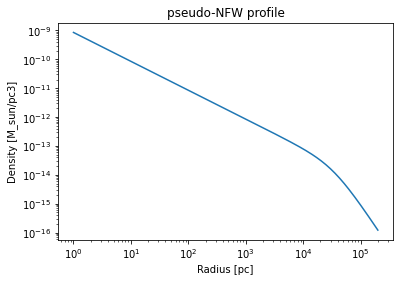

In [11]:
#First we sampled the profile, and plot it for visual inspection
pseudo_NFW = pNFW(rho_0=rho_0, r_s=r_s, r=r)

plt.loglog(r, pseudo_NFW)
plt.title("pseudo-NFW profile")
plt.xlabel("Radius [pc]")
plt.ylabel("Density [M_sun/pc3]")

Iteration: 1  chi2: 0.5086 Nonzero: 15/15
Iteration: 11  chi2: 0.01274 Nonzero: 15/15
Iteration: 17  chi2: 0.01259 Nonzero: 15/15
############################################
 Computation time: 0.22 seconds
 Total Iterations:  17
Nonzero Gaussians:  15
 Unused Gaussians:  0
 Chi2: 0.01259 
 STDEV: 0.007934
 MEANABSDEV: 0.007089
############################################
 Total_Counts      Sigma
############################################
  1.54218e-09     0.804919
  1.51916e-09      1.96948
  1.51241e-09      4.78788
  1.50814e-09      11.6024
  1.50602e-09      28.0634
  1.50589e-09      67.8346
  1.50746e-09       164.04
  1.51012e-09      397.179
  1.51253e-09      962.932
  1.51094e-09      2332.01
  1.50204e-09      5574.89
  1.54274e-09      12576.5
  1.16383e-09      24759.4
  5.10473e-10      47758.7
  1.76148e-10       108707
############################################


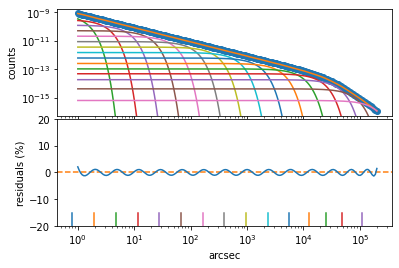

In [12]:
#Finally we set the MGE parametrization
mge = mge_fit_1d.mge_fit_1d(r, pseudo_NFW, quiet=False, plot=True)

Now we save our parameterization

In [13]:
mge_peak  = mge.sol[0]                         #Gaussian peak        [M_sun/pc2]
mge_sigma = mge.sol[1]                         #Gaussian sigma       [pc]
mge_qobs  = np.full_like(mge_peak, 1.0)        #Gaussian axial ratio [ad] **Remember, this is a arbitrary value**

In [15]:
np.savetxt('ESO325_pseudo-DM.txt', np.column_stack([mge_peak, mge_sigma/(distance.value*np.pi/0.648), mge_qobs]),
                            fmt=b'%5.5e\t\t\t %5.5e\t\t %5.5e', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')

#Here, when we save the sigma of each Gaussian we divide by the value (distance * np.pi / 0.648)
 #because the JAM requires that sigma be given in arcsec.